In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Data Preprocessing

In [18]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

## Explore Raw Data

In [19]:
features_df  = pd.read_csv("Data/features.csv")
train_df = pd.read_csv("Data/train.csv")
stores_df = pd.read_csv("Data/stores.csv")
test_df = pd.read_csv("Data/test.csv")

### Explore Features DF

This file contains additional data related to the store, department, and regional activity for the given dates.

In [20]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [21]:
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [24]:
# Imputing CPI and Unemployement values with mean of respective store
features_df['CPI'] = features_df['CPI'].fillna(features_df.groupby('Store')['CPI'].transform('mean'))
features_df['Unemployment'] = features_df['Unemployment'].fillna(features_df.groupby('Store')['Unemployment'].transform('mean'))

### Explore Train/Test DF

This is the historical training data, which covers to 2010-02-05 to 2012-11-01.
`test_df` file is identical to train.csv, except we have withheld the weekly sales.

In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [26]:
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [27]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


In [28]:
test_df.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


Since the test dataset is missing the actual weekly sales for those dates (the y label) becuase this was originally used for a Kaggle competition, let's derive both the dev and test datasets from the train_df for the purposes of our project for now (we may decide to use this test dataset and submit to the Kaggle compeititon later on.

### Explore Stores_DF

This file contains anonymized information about the 45 stores, indicating the type and size of store.

In [29]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [30]:
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


## Merge the Features/Train Datasets together for one DS

In [31]:
features_df = features_df.merge(stores_df, how='inner', on='Store')
df = pd.merge(left=features_df,right=train_df,on=["Store","Date"],how='left')

In [32]:
df.drop("IsHoliday_x",inplace=True,axis=1)
df.rename(columns={"IsHoliday_y":"IsHoliday"},inplace=True)

In [33]:
df.rename(columns={"Type":"Store_Type"},inplace=True)
df.rename(columns={"Size":"Store_Size"},inplace=True)

In [34]:
df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Type,Store_Size,Dept,Weekly_Sales,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,1.0,24924.50,False
1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2.0,50605.27,False
2,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,3.0,13740.12,False
3,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,4.0,39954.04,False
4,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5.0,32229.38,False


In [35]:
df['Date'] = pd.to_datetime(df['Date'])

In [36]:
# Adding week number for imputing
# Reference: https://www.includehelp.com/python/converting-a-pandas-date-to-week-number.aspx
df['Week'] = df['Date'].dt.isocalendar().week

## Missing Value Treatment and Clean Up

In [37]:
# Check is there any missing values across each column
df.isna().sum()

Store                0
Date                 0
Temperature          0
Fuel_Price           0
MarkDown1       270892
MarkDown2       310793
MarkDown3       284667
MarkDown4       286859
MarkDown5       270138
CPI                  0
Unemployment         0
Store_Type           0
Store_Size           0
Dept              1755
Weekly_Sales      1755
IsHoliday         1755
Week                 0
dtype: int64

In [38]:
stores_df.isna().sum()

Store    0
Type     0
Size     0
dtype: int64

In [39]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (features_df.isnull().sum()/features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total missing values', 'Percentage'])
missing_data

,Total missing values,Percentage
MarkDown2,310793.0,0.643346
MarkDown4,286859.0,0.577045
MarkDown3,284667.0,0.558852
MarkDown1,270892.0,0.507692
MarkDown5,270138.0,0.505495
IsHoliday,1755.0,0.000000
Weekly_Sales,1755.0,NaN
Dept,1755.0,NaN
Store_Type,0.0,NaN
Store_Size,0.0,NaN


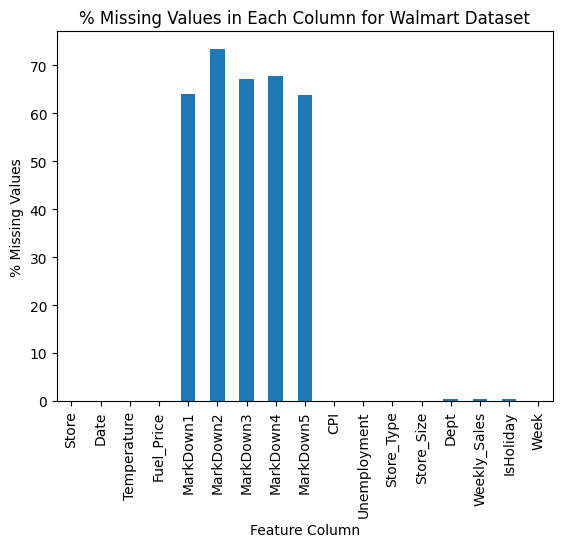

In [40]:
# sns.barplot(features.isnull())
# plt.show()

df_nulls = (df.isna().sum()/len(df)) *100
df_nulls.plot(kind = "bar",
               xlabel = "Feature Column",
               title = "% Missing Values in Each Column for Walmart Dataset",
               ylabel = "% Missing Values")
plt.show()

Some of the info needed for the target y label and relevant department is missing, let's see how many rows are missing and drop them if it's possible

In [41]:
df[df['Dept'].isnull()]

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Type,Store_Size,Dept,Weekly_Sales,IsHoliday,Week
10244,1,2012-11-02,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573000,A,151315,NaN,NaN,NaN,44
10245,1,2012-11-09,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573000,A,151315,NaN,NaN,NaN,45
10246,1,2012-11-16,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573000,A,151315,NaN,NaN,NaN,46
10247,1,2012-11-23,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573000,A,151315,NaN,NaN,NaN,47
10248,1,2012-11-30,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573000,A,151315,NaN,NaN,NaN,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423320,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,187.298763,8.640467,B,118221,NaN,NaN,NaN,26
423321,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,187.298763,8.640467,B,118221,NaN,NaN,NaN,27
423322,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,187.298763,8.640467,B,118221,NaN,NaN,NaN,28
423323,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,187.298763,8.640467,B,118221,NaN,NaN,NaN,29


Only a very small subset of the dataset contains NaNs in the Dept column (and it seems that the NaNs in thr Weekly Sales Column are on the , so let's just drop those rows.

In [42]:
df = df[df['Dept'].notna()]

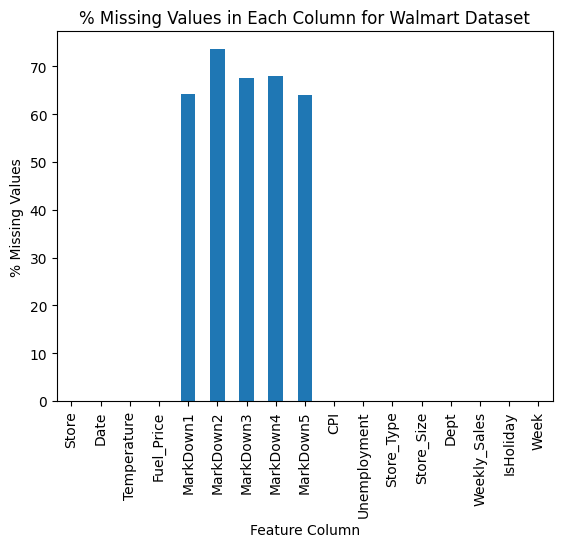

In [43]:
df_nulls = (df.isna().sum()/len(df)) *100
df_nulls.plot(kind = "bar",
               xlabel = "Feature Column",
               title = "% Missing Values in Each Column for Walmart Dataset",
               ylabel = "% Missing Values")
plt.show()

### MarkDown Column Clean-Up

From competition: MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NaN.

In [44]:
df[df['MarkDown1'].notna()]

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Type,Store_Size,Dept,Weekly_Sales,IsHoliday,Week
6587,1,2011-11-11,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,217.998085,7.866,A,151315,1.0,18689.54,False,45
6588,1,2011-11-11,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,217.998085,7.866,A,151315,2.0,44936.47,False,45
6589,1,2011-11-11,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,217.998085,7.866,A,151315,3.0,9959.64,False,45
6590,1,2011-11-11,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,217.998085,7.866,A,151315,4.0,36826.52,False,45
6591,1,2011-11-11,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,217.998085,7.866,A,151315,5.0,31002.65,False,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423281,45,2012-10-26,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667,B,118221,93.0,2487.80,False,43
423282,45,2012-10-26,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667,B,118221,94.0,5203.31,False,43
423283,45,2012-10-26,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667,B,118221,95.0,56017.47,False,43
423284,45,2012-10-26,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667,B,118221,97.0,6817.48,False,43


A lot of data from 1 year is missing markdowns, and there are NaNs, so for these NaNs we may want to consider a mean simple imputer based on the department and store type.

### Imputing Markdown Data


<b>First Step</b>: Replacing missing markdown data with the average across similar departments during the same year week.<br>
<b>Second Step</b>: Replace the remaining missing values with the average value across each markdown type (this is to account for week 44 where no markdown values were registered)

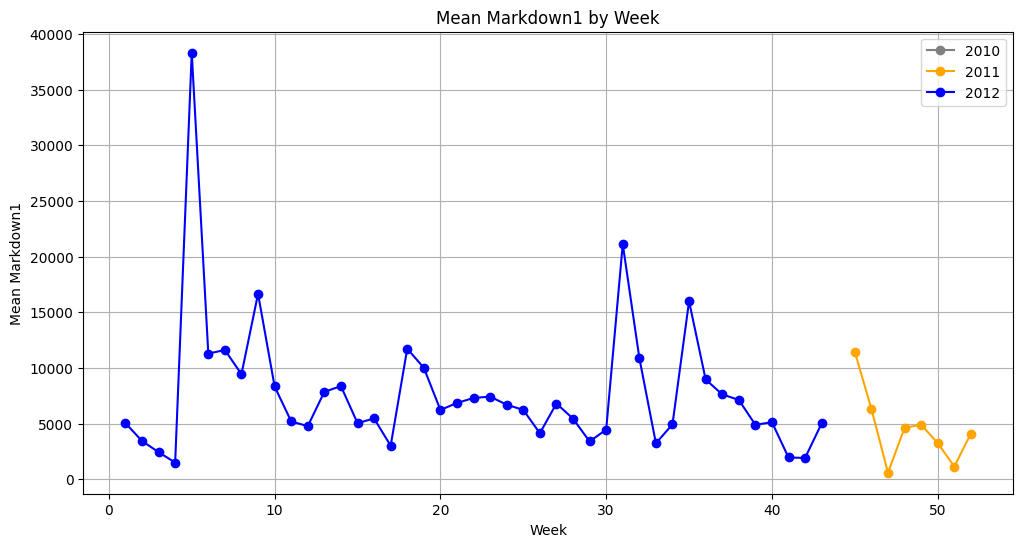

In [45]:
# Show missing values around week 44
markdown_mean_2010 = df[pd.to_datetime(df['Date']).dt.year == 2010].groupby('Week')['MarkDown1'].mean()
markdown_mean_2011 = df[pd.to_datetime(df['Date']).dt.year == 2011].groupby('Week')['MarkDown1'].mean()
markdown_mean_2012 = df[pd.to_datetime(df['Date']).dt.year == 2012].groupby('Week')['MarkDown1'].mean()

# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(markdown_mean_2010.index, markdown_mean_2010.values, label = '2010', color = 'grey', marker='o', linestyle='-')
plt.plot(markdown_mean_2011.index, markdown_mean_2011.values, label = '2011', color = 'orange', marker='o', linestyle='-')
plt.plot(markdown_mean_2012.index, markdown_mean_2012.values, label = '2012', color = 'blue', marker='o', linestyle='-')

plt.title('Mean Markdown1 by Week')
plt.xlabel('Week')
plt.ylabel('Mean Markdown1')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
#reference from: 
# https://stackoverflow.com/questions/73411674/scikit-learn-imputer-in-a-pandas-dataframe-group-by-id

# Replace MarkDown NaN with mean amount of same dept and store type
df['MarkDown1'] = df.groupby(["Dept",  "Week"]).MarkDown1.transform(lambda x: x.fillna(x.mean()))
df['MarkDown2'] = df.groupby(["Dept",  "Week"]).MarkDown2.transform(lambda x: x.fillna(x.mean()))
df['MarkDown3'] = df.groupby(["Dept",  "Week"]).MarkDown3.transform(lambda x: x.fillna(x.mean()))
df['MarkDown4'] = df.groupby(["Dept",  "Week"]).MarkDown4.transform(lambda x: x.fillna(x.mean()))
df['MarkDown5'] = df.groupby(["Dept",  "Week"]).MarkDown5.transform(lambda x: x.fillna(x.mean()))

In [47]:
df.isna().sum()

Store               0
Date                0
Temperature         0
Fuel_Price          0
MarkDown1        6288
MarkDown2       33307
MarkDown3        6985
MarkDown4        6288
MarkDown5        6288
CPI                 0
Unemployment        0
Store_Type          0
Store_Size          0
Dept                0
Weekly_Sales        0
IsHoliday           0
Week                0
dtype: int64

In [48]:
# Second step of imputation. Replacing missing values with the mean across markdown types.
df['MarkDown1'].fillna(df['MarkDown1'].mean(), inplace= True)
df['MarkDown2'].fillna(df['MarkDown2'].mean(), inplace= True)
df['MarkDown3'].fillna(df['MarkDown3'].mean(), inplace= True)
df['MarkDown4'].fillna(df['MarkDown4'].mean(), inplace= True)
df['MarkDown5'].fillna(df['MarkDown5'].mean(), inplace= True)

In [49]:
df.isna().sum()

Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Store_Type      0
Store_Size      0
Dept            0
Weekly_Sales    0
IsHoliday       0
Week            0
dtype: int64

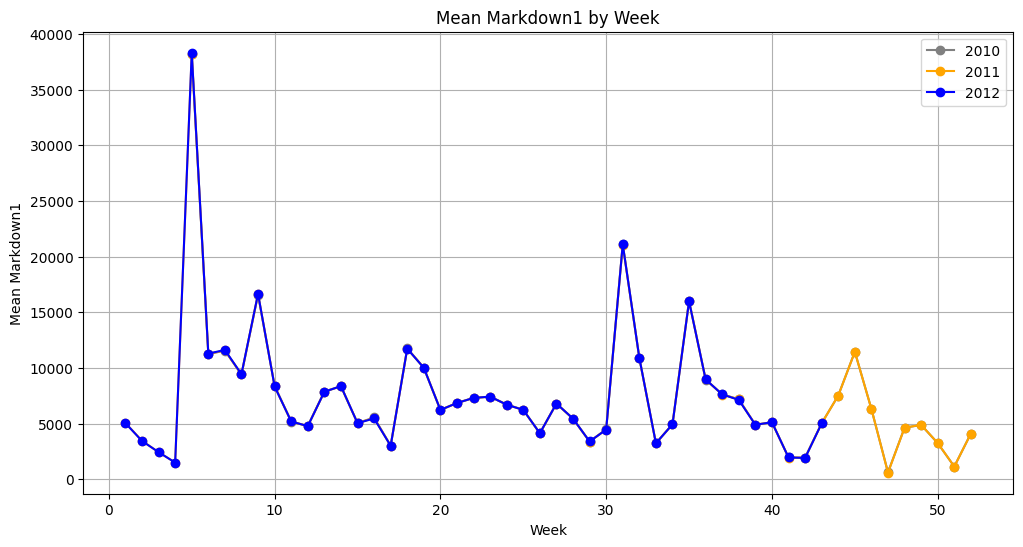

In [50]:
# Showing mean markdown1 after imputation
markdown_mean_2010 = df[pd.to_datetime(df['Date']).dt.year == 2010].groupby('Week')['MarkDown1'].mean()
markdown_mean_2011 = df[pd.to_datetime(df['Date']).dt.year == 2011].groupby('Week')['MarkDown1'].mean()
markdown_mean_2012 = df[pd.to_datetime(df['Date']).dt.year == 2012].groupby('Week')['MarkDown1'].mean()

# Create a plot
plt.figure(figsize=(12, 6))
plt.plot(markdown_mean_2010.index, markdown_mean_2010.values, label = '2010', color = 'grey', marker='o', linestyle='-')
plt.plot(markdown_mean_2011.index, markdown_mean_2011.values, label = '2011', color = 'orange', marker='o', linestyle='-')
plt.plot(markdown_mean_2012.index, markdown_mean_2012.values, label = '2012', color = 'blue', marker='o', linestyle='-')

plt.title('Mean Markdown1 by Week')
plt.xlabel('Week')
plt.ylabel('Mean Markdown1')
plt.legend()
plt.grid(True)
plt.show()

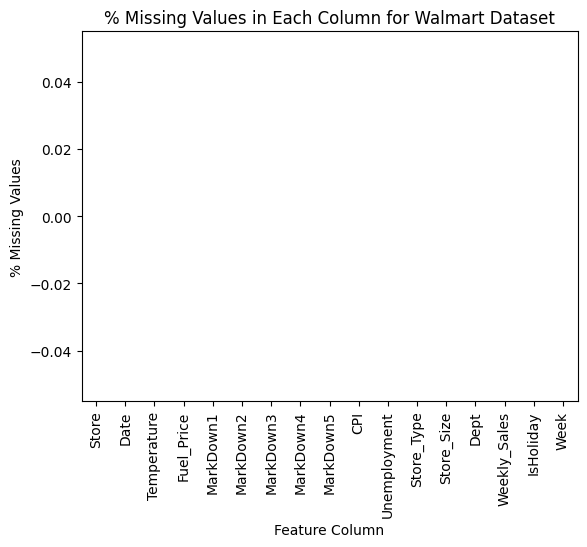

In [51]:
df_nulls = (df.isna().sum()/len(df)) *100
df_nulls.plot(kind = "bar",
               xlabel = "Feature Column",
               title = "% Missing Values in Each Column for Walmart Dataset",
               ylabel = "% Missing Values")
plt.show()

It appears that there is a very small % of missing values in the MarkDown columns even after imputation. This is likely because there is no existing data available for the store type and dept that can be used to impute these nulls. For these very small number cases, we will just use the simple imputation of MarkDown by Dept (although the Store Type may impact the MarkDown amount in these columns, since the # of columns that this impacts is very small, we expect the impact to also be very small.

No more missing values!

In [52]:
# save a copy for some feature importance later
no_na_df = df.copy()

### Categorical Variables/Data Clean-Up

Before handling the other missing values (i.e. MarkDown columns, let's do some clean-up.

In [53]:
#df['Date'] = pd.to_datetime(df['Date'])

In [54]:
from sklearn.impute import SimpleImputer

df["IsHoliday"] = pd.get_dummies(df["IsHoliday"], 
                drop_first = True, 
                dtype = int )


In [55]:
df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Type,Store_Size,Dept,Weekly_Sales,IsHoliday,Week
0,1,2010-02-05,42.31,2.572,36093.593556,2812.054889,142.414,29920.769302,5950.383333,211.096358,8.106,A,151315,1.0,24924.50,0,5
1,1,2010-02-05,42.31,2.572,36093.593556,2812.054889,142.414,29920.769302,5950.383333,211.096358,8.106,A,151315,2.0,50605.27,0,5
2,1,2010-02-05,42.31,2.572,36093.593556,2812.054889,142.414,29920.769302,5950.383333,211.096358,8.106,A,151315,3.0,13740.12,0,5
3,1,2010-02-05,42.31,2.572,36093.593556,2812.054889,142.414,29920.769302,5950.383333,211.096358,8.106,A,151315,4.0,39954.04,0,5
4,1,2010-02-05,42.31,2.572,36093.593556,2812.054889,142.414,29920.769302,5950.383333,211.096358,8.106,A,151315,5.0,32229.38,0,5


In [56]:
df["Store_Type"].nunique()

3

We do not know if store type has any ordinal importance, so we will just use a simple imputer for this/

In [57]:
type_dummies = pd.get_dummies(df["Store_Type"], 
                drop_first = True, 
                dtype = int )

df = df.drop(["Store_Type"], axis = 1)

df = pd.concat([df, type_dummies], axis=1)
df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Size,Dept,Weekly_Sales,IsHoliday,Week,B,C
0,1,2010-02-05,42.31,2.572,36093.593556,2812.054889,142.414,29920.769302,5950.383333,211.096358,8.106,151315,1.0,24924.50,0,5,0,0
1,1,2010-02-05,42.31,2.572,36093.593556,2812.054889,142.414,29920.769302,5950.383333,211.096358,8.106,151315,2.0,50605.27,0,5,0,0
2,1,2010-02-05,42.31,2.572,36093.593556,2812.054889,142.414,29920.769302,5950.383333,211.096358,8.106,151315,3.0,13740.12,0,5,0,0
3,1,2010-02-05,42.31,2.572,36093.593556,2812.054889,142.414,29920.769302,5950.383333,211.096358,8.106,151315,4.0,39954.04,0,5,0,0
4,1,2010-02-05,42.31,2.572,36093.593556,2812.054889,142.414,29920.769302,5950.383333,211.096358,8.106,151315,5.0,32229.38,0,5,0,0


In [58]:
df.rename(columns={"B":"Store_Type_B"},inplace=True)
df.rename(columns={"C":"Store_Type_C"},inplace=True)
df.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Size,Dept,Weekly_Sales,IsHoliday,Week,Store_Type_B,Store_Type_C
423281,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,118221,93.0,2487.80,0,43,1,0
423282,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,118221,94.0,5203.31,0,43,1,0
423283,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,118221,95.0,56017.47,0,43,1,0
423284,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,118221,97.0,6817.48,0,43,1,0
423285,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,118221,98.0,1076.80,0,43,1,0


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421570 entries, 0 to 423285
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Date          421570 non-null  datetime64[ns]
 2   Temperature   421570 non-null  float64       
 3   Fuel_Price    421570 non-null  float64       
 4   MarkDown1     421570 non-null  float64       
 5   MarkDown2     421570 non-null  float64       
 6   MarkDown3     421570 non-null  float64       
 7   MarkDown4     421570 non-null  float64       
 8   MarkDown5     421570 non-null  float64       
 9   CPI           421570 non-null  float64       
 10  Unemployment  421570 non-null  float64       
 11  Store_Size    421570 non-null  int64         
 12  Dept          421570 non-null  float64       
 13  Weekly_Sales  421570 non-null  float64       
 14  IsHoliday     421570 non-null  int64         
 15  Week          421570 n

### Splitting the Data

In [60]:
# sort by date for time series forecasting
df = df.sort_values(by = 'Date')

# we delete negative weekly sales as they only represent 0.3% of the data.
# we are unsure about the significance of negative sales. (negative sales is different negative profit)
df = df[df['Weekly_Sales'] > 0]

# split data into features and labels
df_X = df.drop(columns=['Weekly_Sales'])
df_y = df['Weekly_Sales']

## Exploratory Data Analysis

### Macro Analyses

Before looking into each department's trends for patterns, let's look at the overall dataset patterns

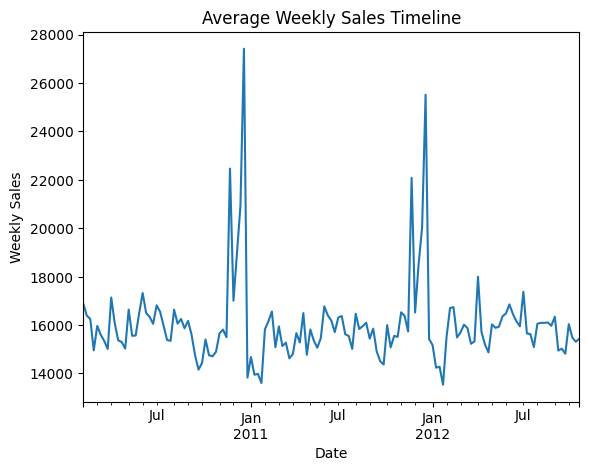

In [61]:
sales_df = df.groupby("Date")["Weekly_Sales"].mean().transpose().plot(
                                                                                                                  kind = "line",
                                                                     title = "Average Weekly Sales Timeline",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Date")

Let's zoom in to 1 year of sales, like Jan 2011 - Jan 2012.

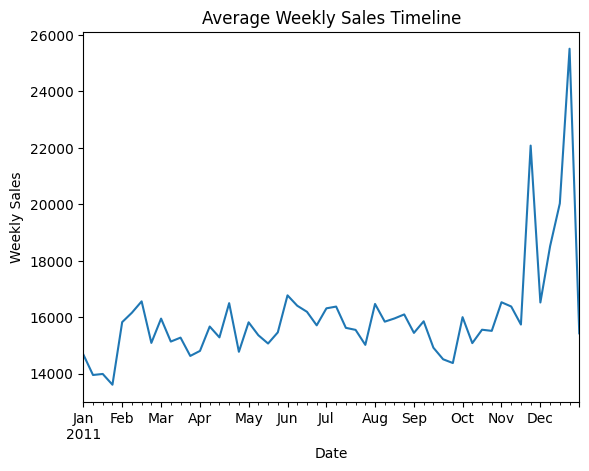

In [62]:
sales_df = df[(df["Date"] > "2011-01-01") & (df["Date"] <= "2012-01-01")].groupby("Date")["Weekly_Sales"].mean().transpose().plot(
                                                                                                                  kind = "line",
                                                                     title = "Average Weekly Sales Timeline",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Date")

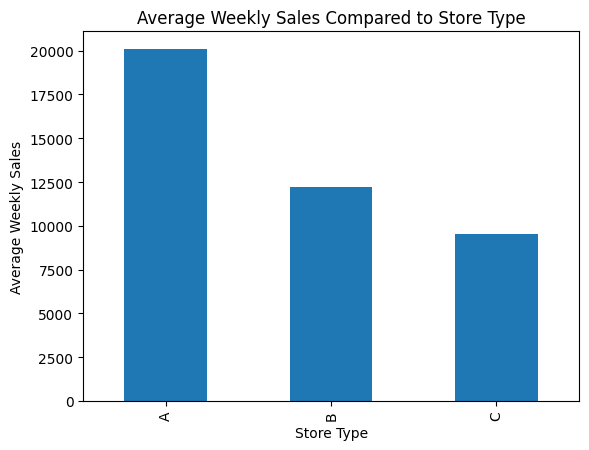

In [63]:
sales_df = no_na_df.groupby("Store_Type")["Weekly_Sales"].mean().plot(kind = "bar",
                                                                     title = "Average Weekly Sales Compared to Store Type",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Store Type")

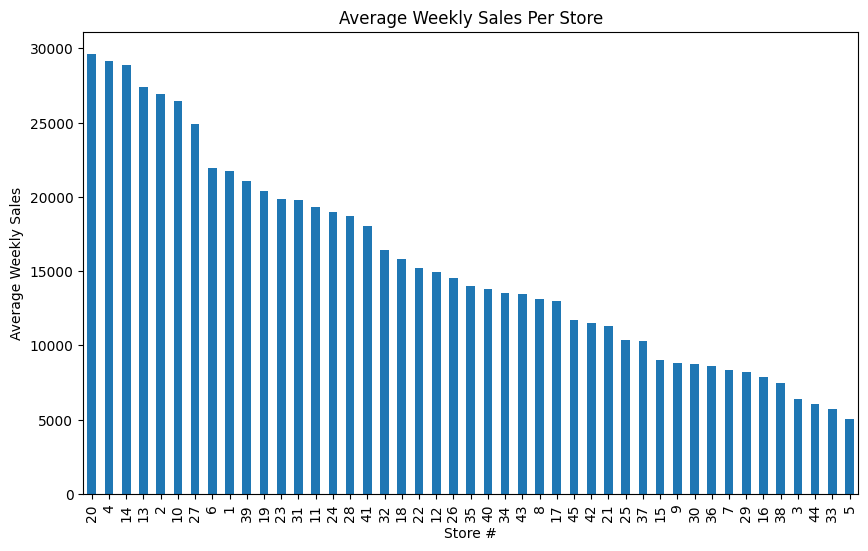

In [64]:
plt.figure(figsize=(10,6))
sales_df = df.groupby("Store")["Weekly_Sales"].mean().sort_values(ascending=False).transpose().plot(kind = "bar",
                                                                     title = "Average Weekly Sales Per Store",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Store #")


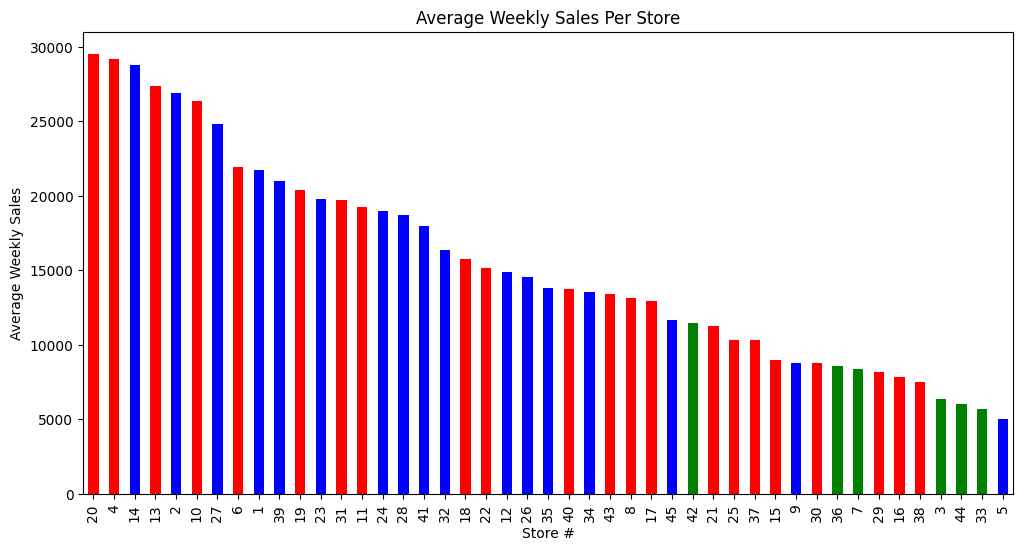

In [67]:
plt.figure(figsize=(12,6))
colors = {'A': 'r', 'B': 'b', 'C': 'g'}
sales_df = no_na_df.groupby("Store")["Weekly_Sales"].mean().sort_values(ascending=False).transpose().plot(kind = "bar",
                                                                    color=[colors[i] for i in no_na_df.groupby("Store")['Store_Type'].max()],
                                                                     title = "Average Weekly Sales Per Store",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Store #")
#sales_df.legend(colors[i] for i in colors)
#type A = red, type B = blue, type C = green - there is no easy way to add this as a legend
#sales_df.)


Color legend isn't showing up, but we see that type is not impactful to store sales except store type C sales tend to have lower weekly sales than store types A and B.

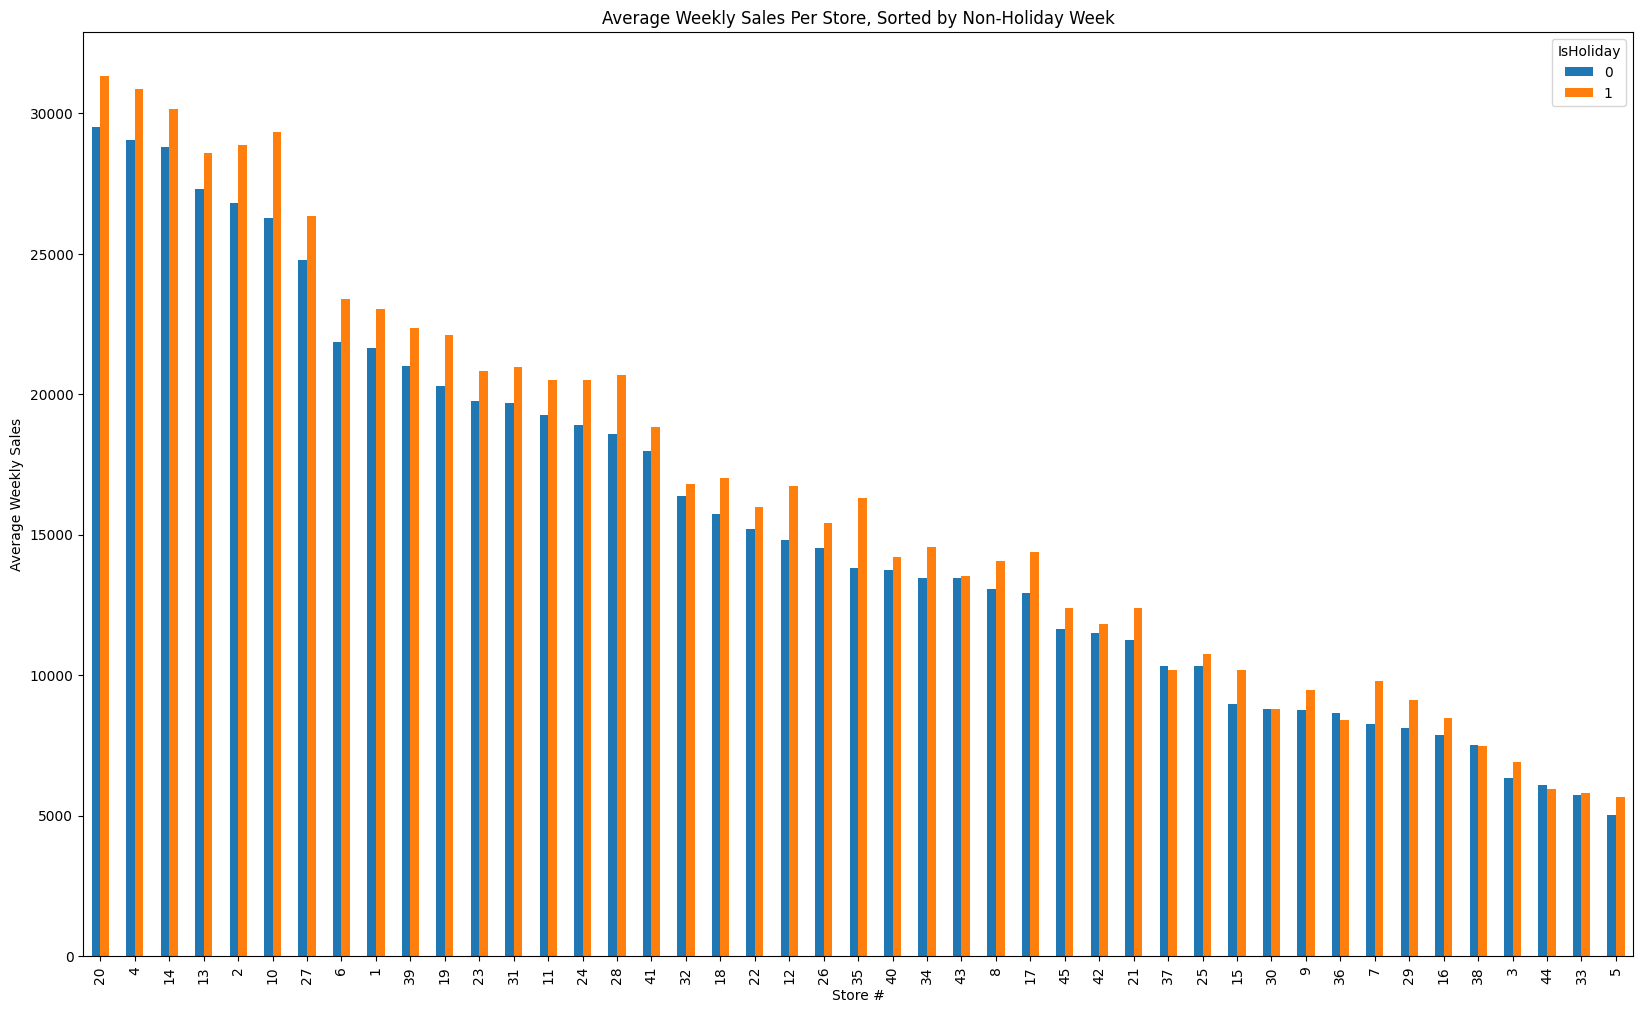

In [68]:


sales_df = df.groupby(["Store", "IsHoliday"])["Weekly_Sales"].mean().unstack().sort_values(by =0,ascending=False).plot(figsize=(20,12),
                                                                                                        kind = "bar",
                                                                     title = "Average Weekly Sales Per Store, Sorted by Non-Holiday Week",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Store #")

This chart is in similar trend to the overall dept weekly sales chart, so we will ignore this.

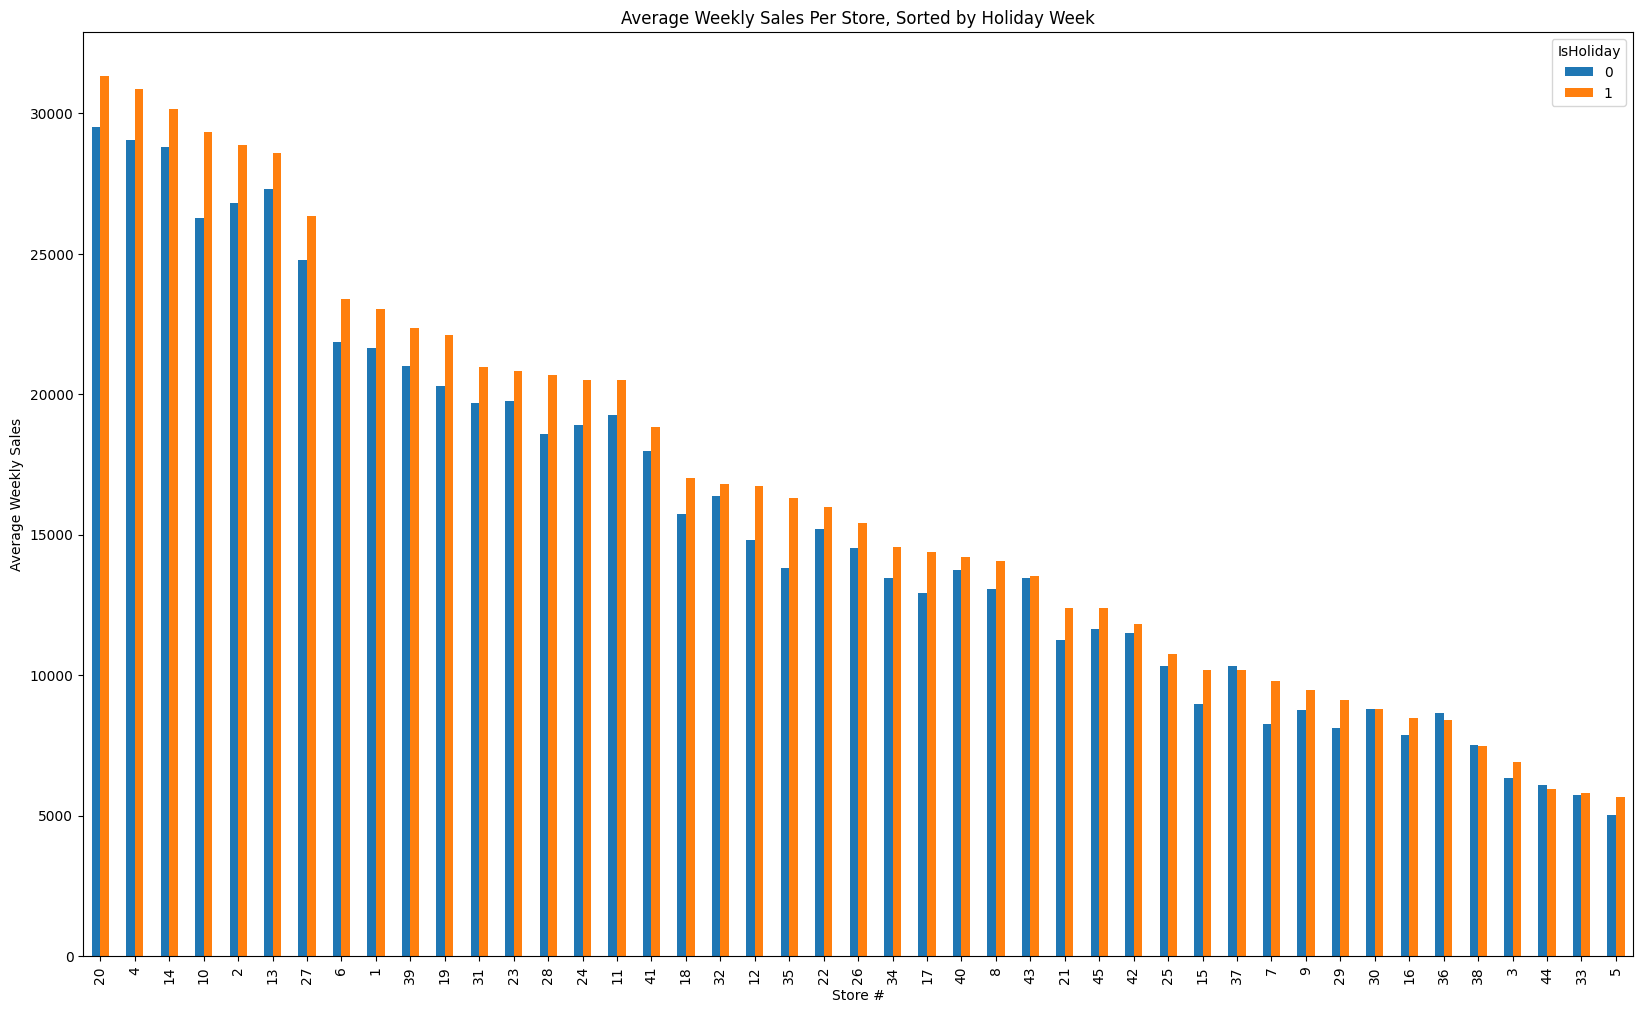

In [69]:


sales_df = df.groupby(["Store", "IsHoliday"])["Weekly_Sales"].mean().unstack().sort_values(by =1,ascending=False).plot(figsize=(20,12),
                                                                                                        kind = "bar",
                                                                     title = "Average Weekly Sales Per Store, Sorted by Holiday Week",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Store #")




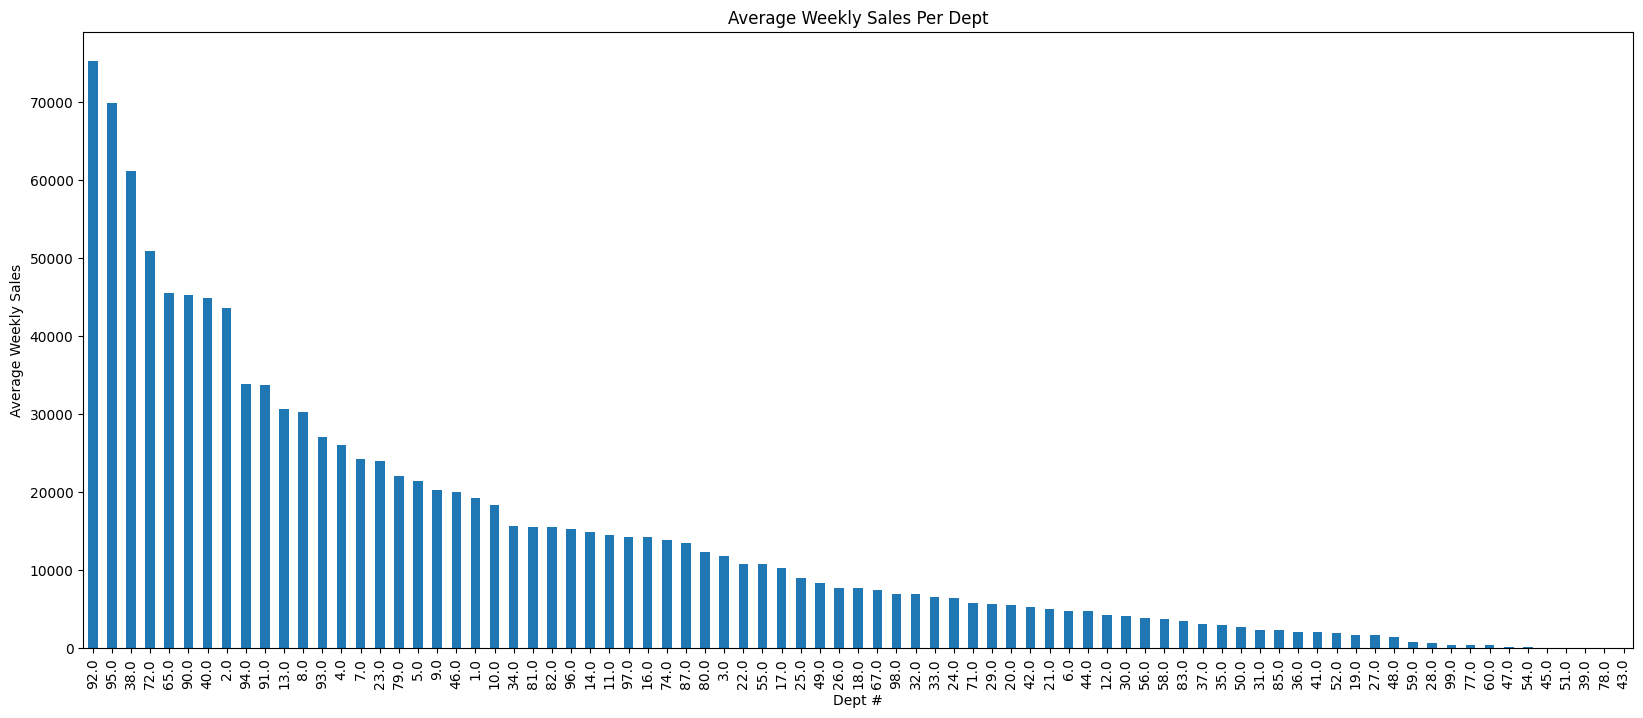

In [70]:
sales_df = df.groupby("Dept")["Weekly_Sales"].mean().sort_values(ascending=False).transpose().plot(kind = "bar",
                                                                     figsize = (20,8),
                                                                            title = "Average Weekly Sales Per Dept",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Dept #")

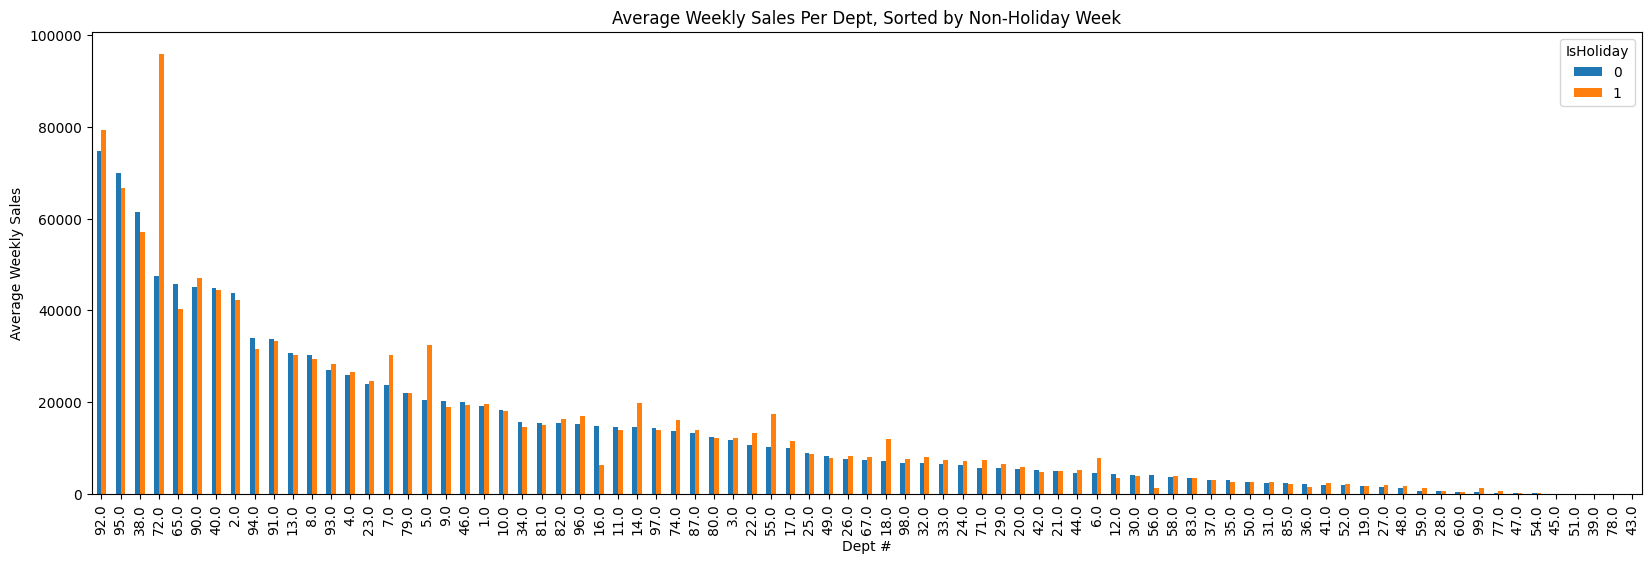

In [71]:
sales_df = df.groupby(["Dept", "IsHoliday"])["Weekly_Sales"].mean().unstack().sort_values(by =0,ascending=False).plot(figsize=(20,6),
                                                                                                        kind = "bar",
                                                                     title = "Average Weekly Sales Per Dept, Sorted by Non-Holiday Week",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Dept #")

This chart is in similar trend to the overall dept weekly sales chart, so we will ignore this.

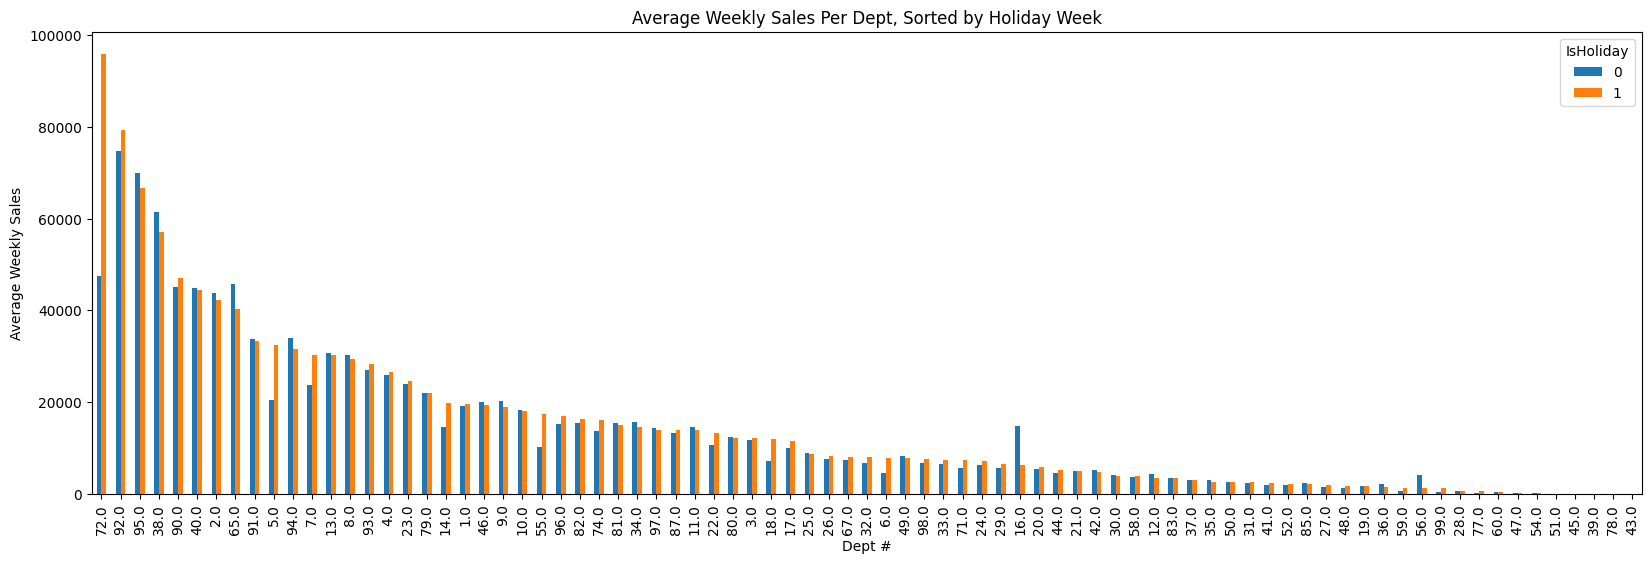

In [72]:
sales_df = df.groupby(["Dept", "IsHoliday"])["Weekly_Sales"].mean().unstack().sort_values(by =1,ascending=False).plot(figsize=(20,6),
                                                                                                        kind = "bar",
                                                                     title = "Average Weekly Sales Per Dept, Sorted by Holiday Week",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Dept #")




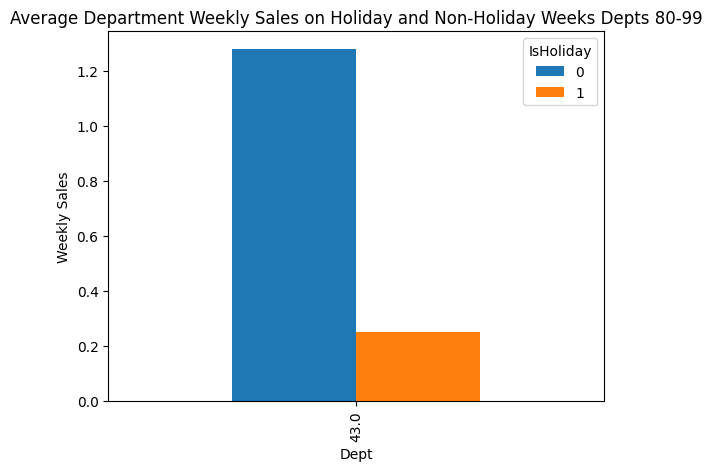

In [73]:
# sanity check to make sure there are sales, even in the worst performing dept
holiday_df6 = df[df["Dept"] == 43.0].groupby(["IsHoliday","Dept"])["Weekly_Sales"].mean().unstack().transpose().plot(
                                                                                                                  kind = "bar",
                                                                     title = "Average Department Weekly Sales on Holiday and Non-Holiday Weeks Depts 80-99",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Dept")

plt.subplots_adjust(
                    wspace=0.5,
                    hspace=0.5)
plt.show()

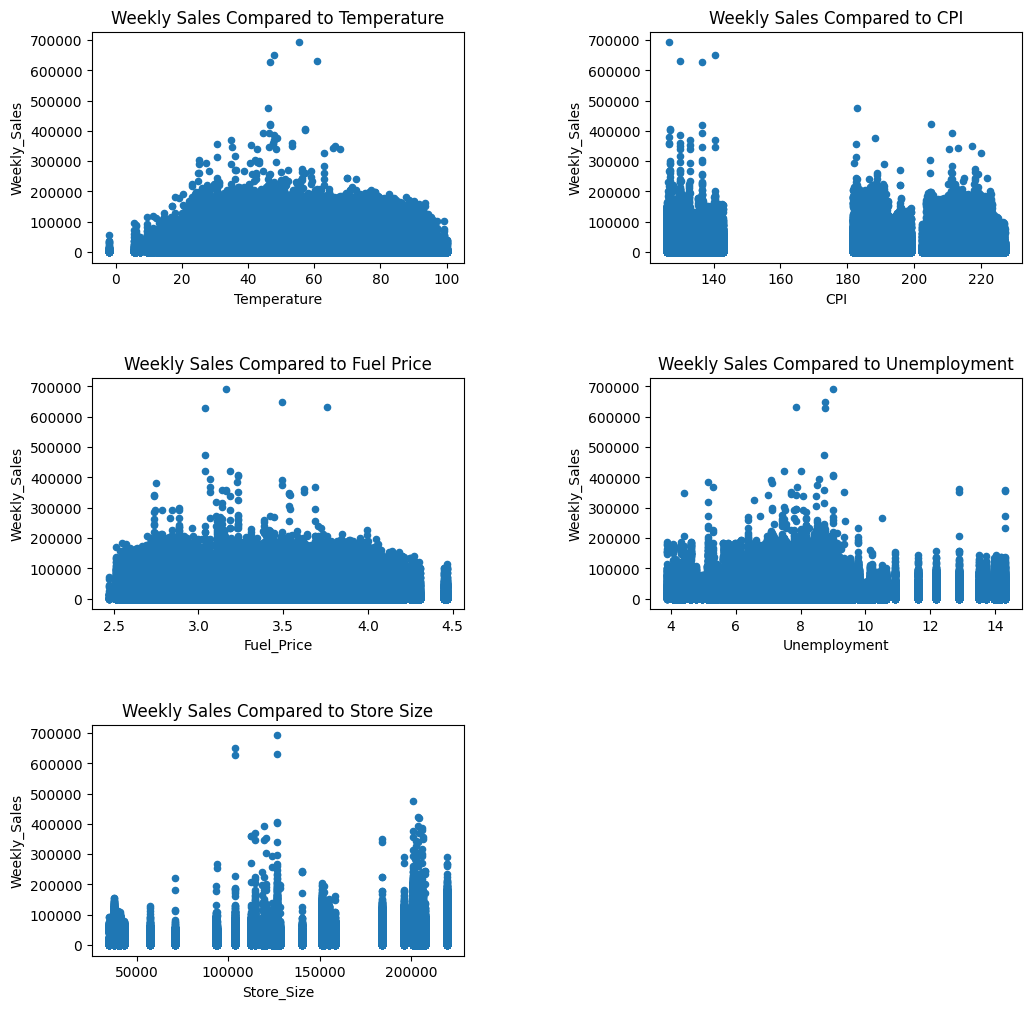

In [74]:
### Code here
fig, axs = plt.subplots(3,2)
# 
fig.set_size_inches(12, 12) # from https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure.set_size_inches

#figure, axis = plt.subplots(2, 2)
temp_df = df.plot(ax = axs[0,0],
                    kind = "scatter",
                    x = "Temperature",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to Temperature")

cpi_df = df.plot(ax = axs[0,1],
                    kind = "scatter",
                    x = "CPI",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to CPI")

fuel_df = df.plot(ax = axs[1,0],
                    kind = "scatter",
                    x = "Fuel_Price",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to Fuel Price")

unemp_df = df.plot(ax = axs[1,1],
                    kind = "scatter",
                    x = "Unemployment",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to Unemployment")

store_size_df = df.plot(ax = axs[2,0],
                    kind = "scatter",
                    x = "Store_Size",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to Store Size")
fig.delaxes(axs[2][1])
plt.subplots_adjust(
                    wspace=0.5,
                    hspace=0.5)
plt.show()

We see some features such as temperature, CPI, and unemployment do not really have an impact on weekly sales, so we should consider dropping those variables.

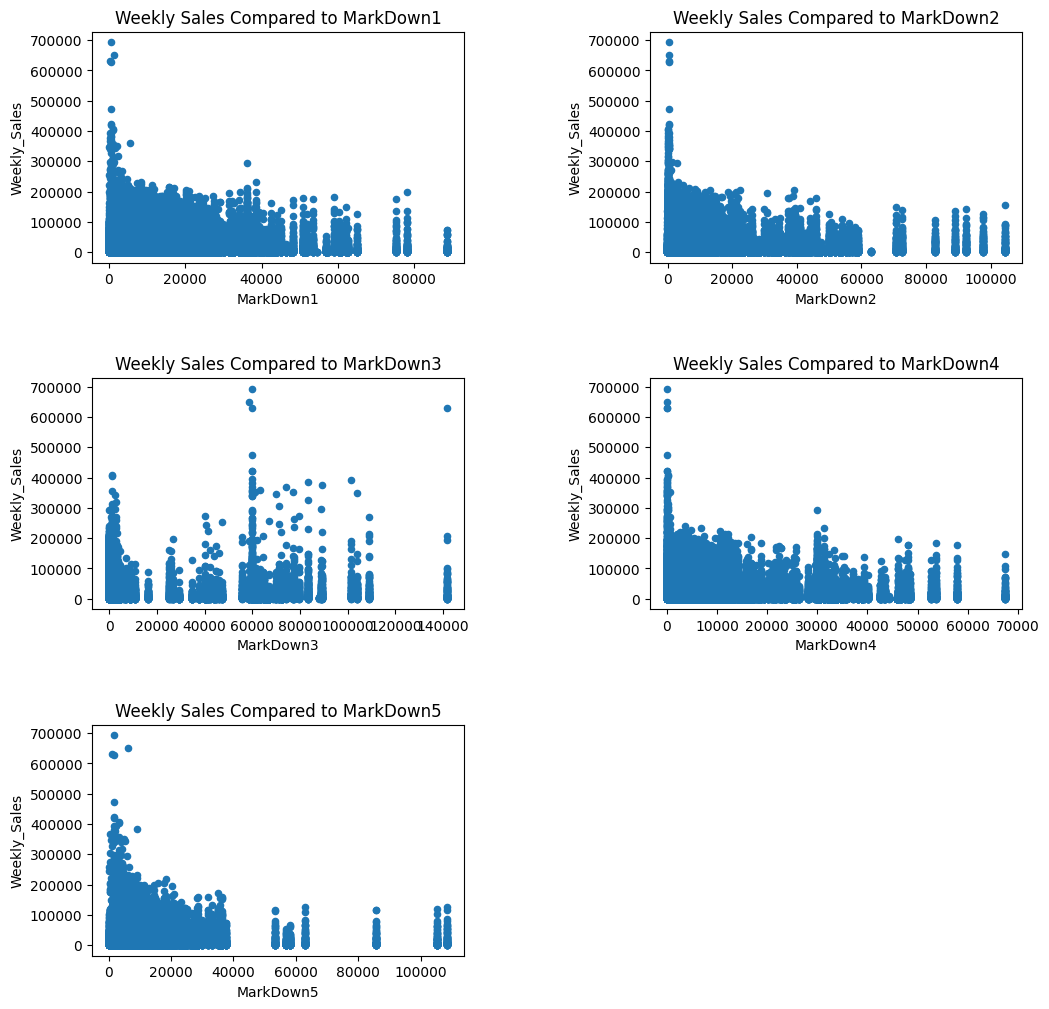

In [75]:
### Code here
fig, axs = plt.subplots(3,2)
# 
fig.set_size_inches(12, 12) # from https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure.set_size_inches

#figure, axis = plt.subplots(2, 2)
md1_df = df.plot(ax = axs[0,0],
                    kind = "scatter",
                    x = "MarkDown1",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to MarkDown1")

md2_df = df.plot(ax = axs[0,1],
                    kind = "scatter",
                    x = "MarkDown2",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to MarkDown2")

md3_df = df.plot(ax = axs[1,0],
                    kind = "scatter",
                    x = "MarkDown3",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to MarkDown3")

md4_df = df.plot(ax = axs[1,1],
                    kind = "scatter",
                    x = "MarkDown4",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to MarkDown4")

md5_df = df.plot(ax = axs[2,0],
                    kind = "scatter",
                    x = "MarkDown5",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to MarkDown5")
fig.delaxes(axs[2][1])
plt.subplots_adjust(
                    wspace=0.5,
                    hspace=0.5)
plt.show()

<Axes: >

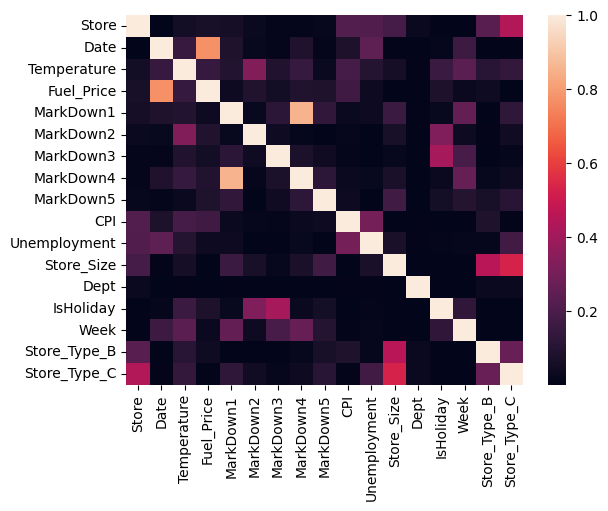

In [76]:
# some help from: https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
sns.heatmap(df_X.corr().abs())

In [77]:
# some help from: https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
print(df_X.corr().abs())

                 Store      Date  Temperature  Fuel_Price  MarkDown1  \
Store         1.000000  0.003159     0.050230    0.065321   0.056538   
Date          0.003159  1.000000     0.146955    0.771944   0.078760   
Temperature   0.050230  0.146955     1.000000    0.143700   0.091959   
Fuel_Price    0.065321  0.771944     0.143700    1.000000   0.034685   
MarkDown1     0.056538  0.078760     0.091959    0.034685   1.000000   
MarkDown2     0.028037  0.020666     0.324372    0.088504   0.021393   
MarkDown3     0.010066  0.008324     0.086519    0.047385   0.114836   
MarkDown4     0.011173  0.082721     0.143065    0.089298   0.855337   
MarkDown5     0.018188  0.007968     0.028204    0.080144   0.131823   
CPI           0.211261  0.077033     0.182223    0.164199   0.028550   
Unemployment  0.208759  0.243463     0.096768    0.033915   0.031458   
Store_Size    0.182763  0.005122     0.058413    0.003632   0.155062   
Dept          0.024258  0.003993     0.004727    0.003544   0.00

There are high correlations between Date/Fuel Price and MarkDown 1 & Markdown We will leave date/fuel price
since that correlation shouldn't impact the model, but we may consider dropping MarkDown 1 
or Markdown 4 or adding in some feature importance metrics.

In [78]:
# drop some uncorrelated variables to weekly sales
df_X = df_X.drop(columns=['CPI', "Unemployment", "Temperature"])

<Axes: >

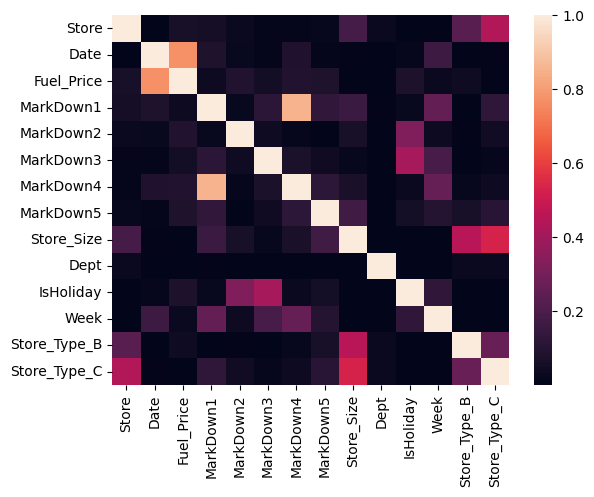

In [79]:
# some help from: https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
sns.heatmap(df_X.corr().abs())

### Micro Analyses

####  Old Dept Analysis



In [61]:
# did this earlier but it's covered in a previous chart

In [80]:
df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Size,Dept,Weekly_Sales,IsHoliday,Week,Store_Type_B,Store_Type_C
0,1,2010-02-05,42.31,2.572,36093.593556,2812.054889,142.4140,29920.769302,5950.383333,211.096358,8.106,151315,1.0,24924.50,0,5,0,0
332087,35,2010-02-05,27.19,2.784,36093.593556,2812.054889,142.4140,29920.769302,5950.383333,135.352461,9.262,103681,3.0,14612.19,0,5,1,0
332088,35,2010-02-05,27.19,2.784,36093.593556,2812.054889,142.4140,29920.769302,5950.383333,135.352461,9.262,103681,4.0,26323.15,0,5,1,0
332089,35,2010-02-05,27.19,2.784,36093.593556,2812.054889,142.4140,29920.769302,5950.383333,135.352461,9.262,103681,5.0,36414.63,0,5,1,0
332090,35,2010-02-05,27.19,2.784,40430.008000,3161.955000,156.4365,32154.346000,6520.385750,135.352461,9.262,103681,6.0,11437.81,0,5,1,0


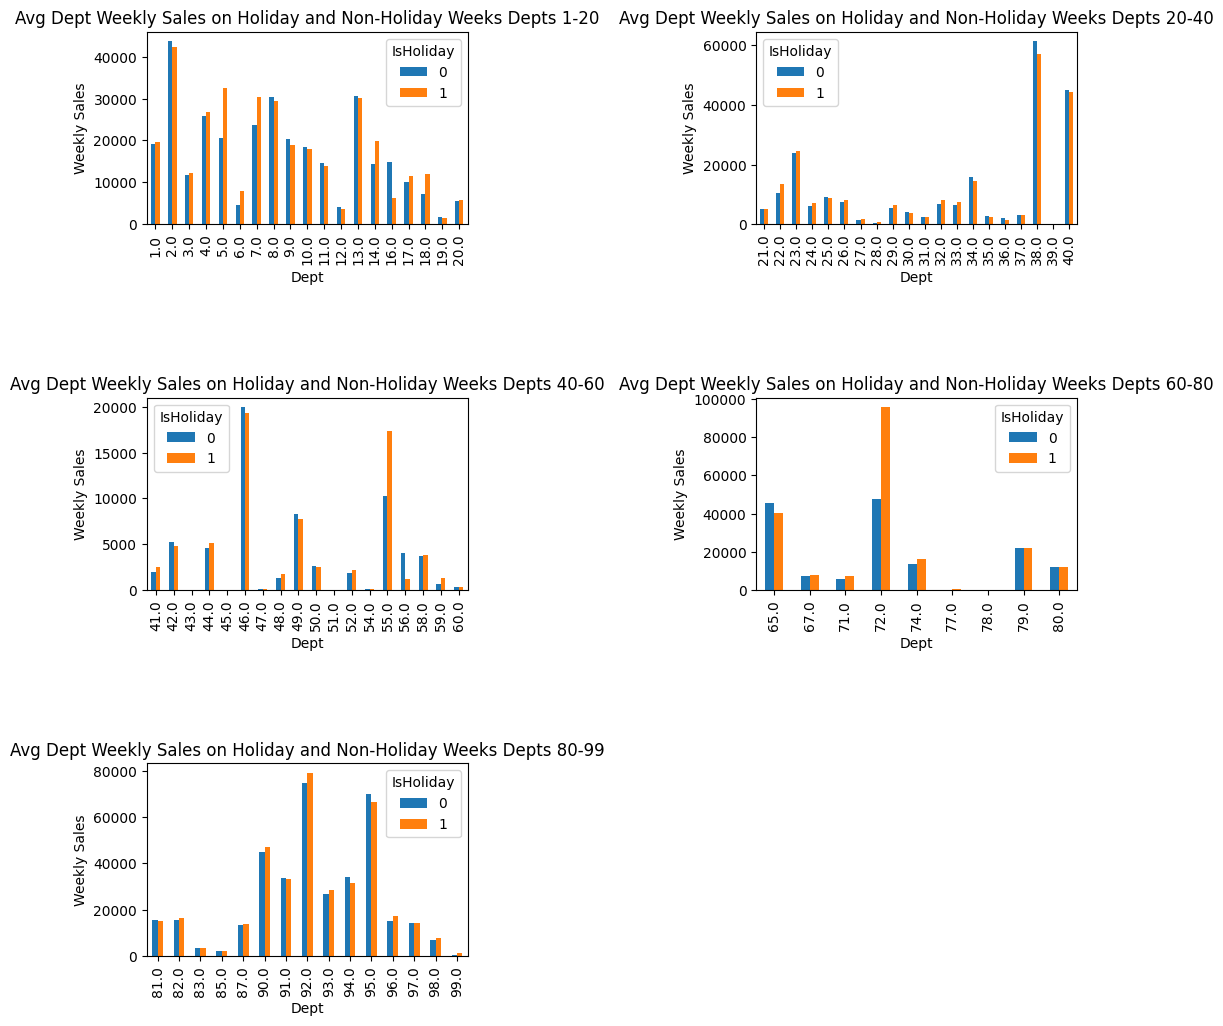

In [84]:
fig, axs = plt.subplots(3,2)

fig.set_size_inches(12, 12) 

holiday_df = df[df["Dept"] <= 20].groupby(["IsHoliday","Dept"])["Weekly_Sales"].mean().unstack().transpose().plot(ax = axs[0,0],
                                                                                                                  kind = "bar",
                                                                     title = "Avg Dept Weekly Sales on Holiday and Non-Holiday Weeks Depts 1-20",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Dept")
                                                                                       
holiday_df2 = df[(df["Dept"] > 20) & (df["Dept"] <= 40)].groupby(["IsHoliday","Dept"])["Weekly_Sales"].mean().unstack().transpose().plot(ax = axs[0,1],
                                                                                                                  kind = "bar",
                                                                     title = "Avg Dept Weekly Sales on Holiday and Non-Holiday Weeks Depts 20-40",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Dept")
holiday_df3 = df[(df["Dept"] > 40) & (df["Dept"] <= 60)].groupby(["IsHoliday","Dept"])["Weekly_Sales"].mean().unstack().transpose().plot(ax = axs[1,0],
                                                                                                                  kind = "bar",
                                                                     title = "Avg Dept Weekly Sales on Holiday and Non-Holiday Weeks Depts 40-60",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Dept")

holiday_df4 = df[(df["Dept"] > 60) & (df["Dept"] <= 80)].groupby(["IsHoliday","Dept"])["Weekly_Sales"].mean().unstack().transpose().plot(ax = axs[1,1],
                                                                                                                  kind = "bar",
                                                                     title = "Avg Dept Weekly Sales on Holiday and Non-Holiday Weeks Depts 60-80",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Dept")

holiday_df5 = df[df["Dept"] > 80].groupby(["IsHoliday","Dept"])["Weekly_Sales"].mean().unstack().transpose().plot(ax = axs[2,0],
                                                                                                                  kind = "bar",
                                                                     title = "Avg Dept Weekly Sales on Holiday and Non-Holiday Weeks Depts 80-99",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Dept")

fig.delaxes(axs[2][1])
plt.subplots_adjust(
                    wspace=0.9,
                    hspace=0.9)
plt.show()

## Train Test Split

Now let's explore some features in our test data.

In [85]:
test_df

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
...,...,...,...,...
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False


Now let's do a time-series friendly split before feeding our data into our initial set of models. Note that we are not using the `test.csv` provided since it does not come with the true `Weekly_Sales` values, so we are deriving our test dataset from the provided train dataset for the focus of this project

### Additional Data Prep

In [86]:
df_X = df_X.drop(columns=["Date"])

##### Split data

In [87]:
#shuffle will be false because we want this to be time series
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, shuffle = False, test_size=0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle = False, test_size=0.2, random_state = 42)

##### Standard Scaler

In [88]:
selected_features = ["Fuel_Price", "MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5", "Store_Size"]
scaler = StandardScaler()

X_train[selected_features] = scaler.fit_transform(X_train[selected_features])
X_val[selected_features] = scaler.transform(X_val[selected_features])
X_test[selected_features] = scaler.transform(X_test[selected_features])

### Initial Model Set-Up Predictions

##### Ridge

In [89]:
alphas = np.logspace(-4, 4, 100)

best_alpha = None
best_val_error = float('inf')
best_model = None

for alpha in alphas:
    current_model = Ridge(alpha=alpha)
    current_model.fit(X_train, y_train)
    
    y_val_pred = current_model.predict(X_val)
    
    val_error = mean_squared_error(y_val, y_val_pred)

    if val_error < best_val_error:
        best_val_error = val_error
        best_alpha = alpha
        best_model = current_model

y_test_pred = best_model.predict(X_test)
y_test_pred = np.maximum(y_test_pred, 0)

test_error = mean_squared_error(y_test, y_test_pred)

# Report the results
print(f"Best Alpha for Ridge Regression: {best_alpha:.4f}")
print(f"Test Mean Squared Error: {test_error:.2f}")

Best Alpha for Ridge Regression: 10000.0000
Test Mean Squared Error: 451661443.23


##### Plot Ridge

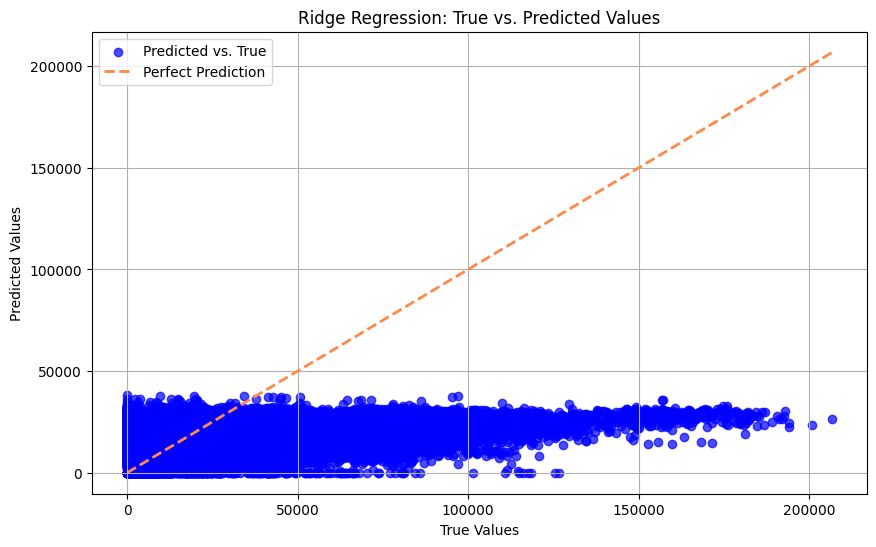

In [90]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Predicted vs. True', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='#ff894b', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Ridge Regression: True vs. Predicted Values')
plt.legend()
plt.grid()
plt.show()

### Xgboost

In [91]:
xgb_model = XGBRegressor()

xgb_model.fit(X_train, y_train)

y_test_pred = xgb_model.predict(X_test)
y_test_pred = np.maximum(y_test_pred, 0)

test_error = mean_squared_error(y_test, y_test_pred)

print(f"Test Mean Squared Error: {test_error:.2f}")

/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Test Mean Squared Error: 49124222.43


/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

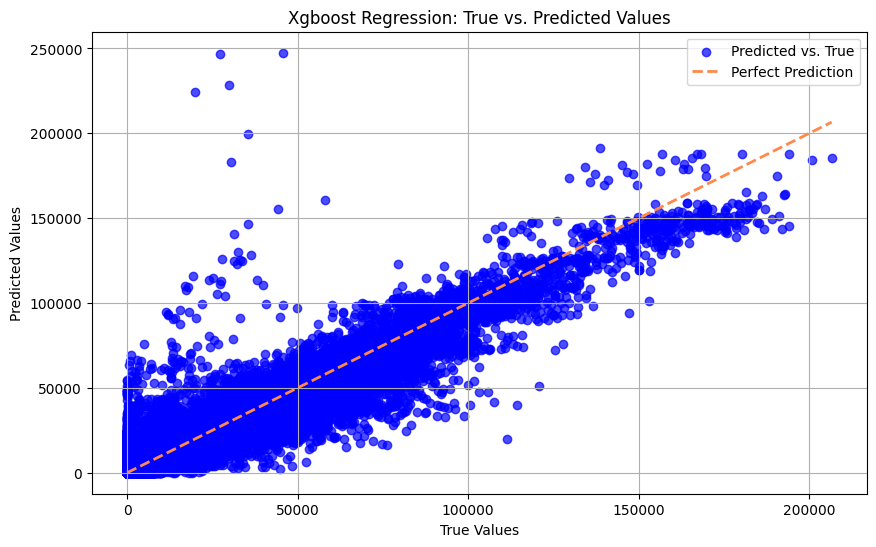

In [92]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Predicted vs. True', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='#ff894b', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Xgboost Regression: True vs. Predicted Values')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#### Future Hypertuning - Takes long time to run
# a lot of warnings but this is the output: "Test Mean Squared Error: 50992727.47"
n_estimators_list = [100, 200, 300]
max_depth_list = [3, 4, 5]
learning_rate_list = [0.01, 0.1, 0.2]
reg_alpha_list = np.logspace(-4, 4, 100)

best_model = None
best_test_error = float('inf')

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for learning_rate in learning_rate_list:
            for reg_alpha in reg_alpha_list:
                current_model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, reg_alpha=reg_alpha)
                                
                current_model.fit(X_train, y_train)

                y_test_pred = current_model.predict(X_val)
                
                test_error = mean_squared_error(y_val, y_test_pred)
                
                if test_error < best_test_error:
                    best_test_error = test_error
                    best_model = current_model

best_model.fit(X_train, y_train)

y_test_pred = best_model.predict(X_test)

test_error = mean_squared_error(y_test, y_test_pred)

print(f"Test Mean Squared Error: {test_error:.2f}")

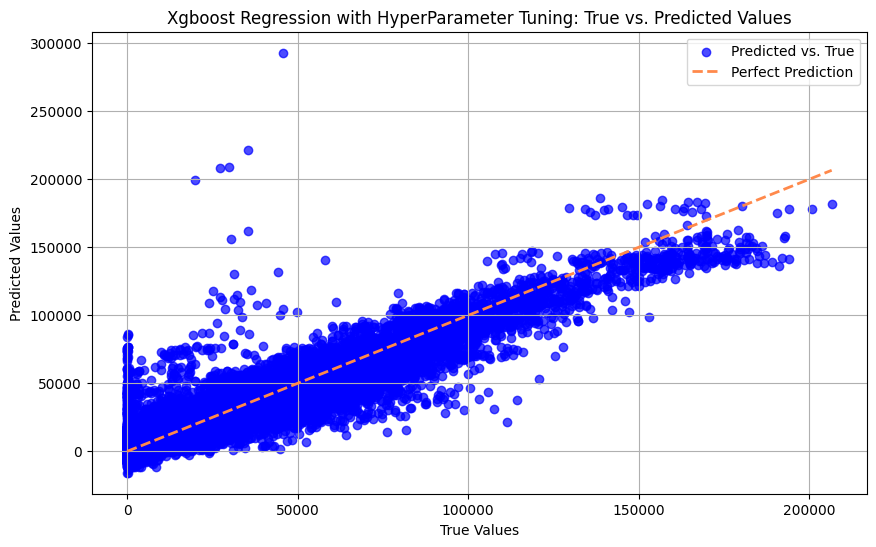

In [97]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Predicted vs. True', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='#ff894b', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Xgboost Regression with HyperParameter Tuning: True vs. Predicted Values')
plt.legend()
plt.grid()
plt.show()

#### Simple Forecasting

In [94]:
forescasting = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
forescasting['Date'] = pd.to_datetime(forescasting['Date'])
forescasting.set_index('Date', inplace=True)
forescasting.sort_index(inplace=True)

/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/raoberman/opt/anaconda3/envs/applied_ml/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


Mean Squared Error: 6947909941600.174


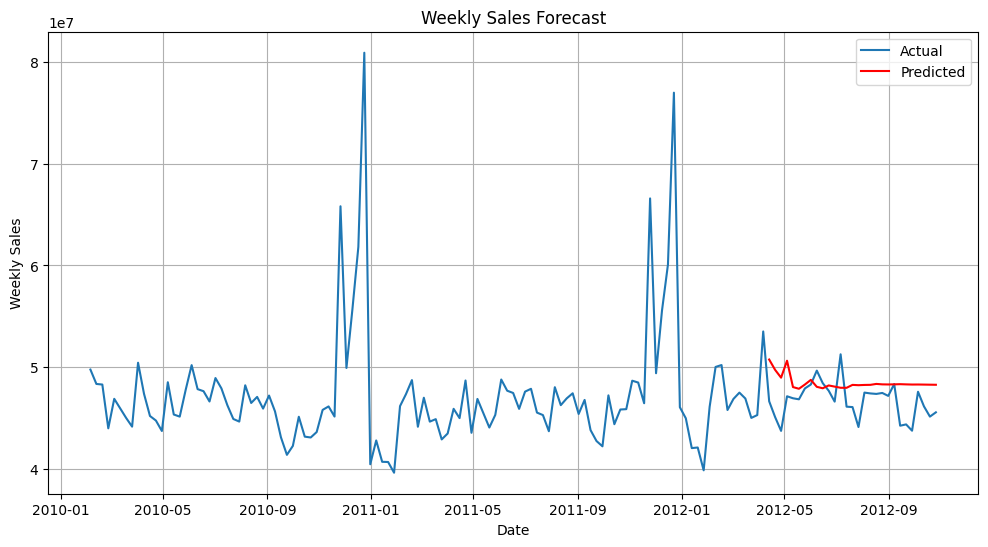

In [95]:
train_size = int(len(forescasting) * 0.8)
train_data = forescasting[:train_size]
test_data = forescasting[train_size:]

model = ARIMA(train_data['Weekly_Sales'], order=(10, 1, 1))
model_fit = model.fit()

predictions = model_fit.get_forecast(steps=len(test_data)).predicted_mean

mse = ((test_data['Weekly_Sales'] - predictions) ** 2).mean()
print(f"Mean Squared Error: {mse}")

plt.figure(figsize=(12, 6))
plt.plot(forescasting.index, forescasting['Weekly_Sales'], label='Actual')
plt.plot(test_data.index, predictions, color='red', label='Predicted')
plt.legend()
plt.title('Weekly Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

#### Additional Plot for showing forecasting importance

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


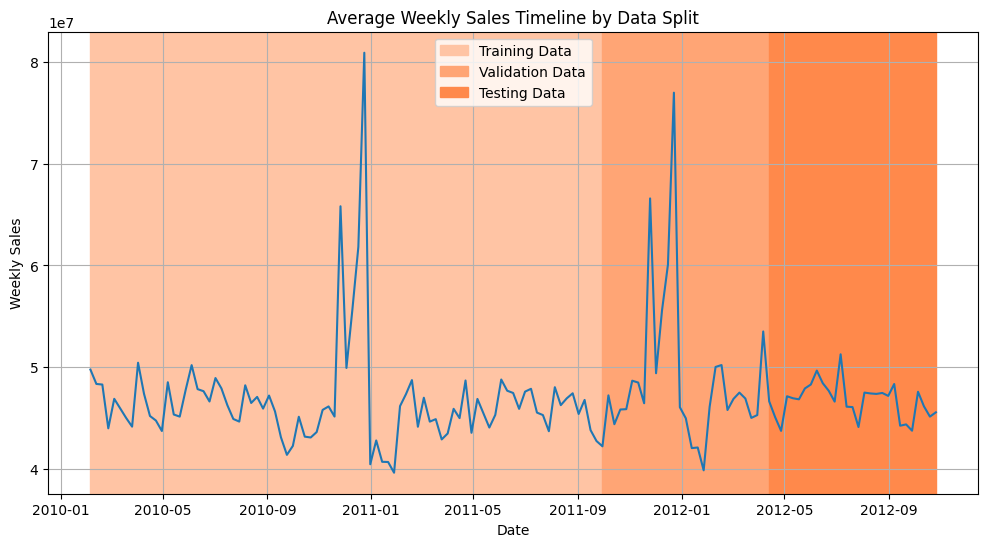

In [96]:
train_size = int(len(df) * 0.6)
val_size = int(len(df) * 0.2)

train_data = df.iloc[train_size]['Date']
val_data = df.iloc[train_size+val_size]['Date']
test_data = df.iloc[-val_size]['Date']

plt.figure(figsize=(12, 6))
plt.plot(forescasting.index, forescasting['Weekly_Sales'])
plt.legend()
plt.title('Average Weekly Sales Timeline by Data Split')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')

plt.grid(True)

plt.axvspan(df.iloc[0]['Date'], train_data, color='#ffc4a4', label='Training Data')
plt.axvspan(train_data, val_data, color='#ffa575', label='Validation Data')
plt.axvspan(val_data, df.iloc[-1]['Date'], color='#ff894b', label='Testing Data')

plt.legend()
plt.show()